In [1]:
from mesmerize_core import *
import tifffile
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# set the parent directory as the top-level directory for your experiment data
# this is mandatory
set_parent_raw_data_path("/home/kushal/caiman_data/")

batch_path = "/home/kushal/caiman_data/mesmerize-core-batch/batch.pickle"

# create a new batch
df = create_batch(batch_path)
df

,algo,name,input_movie_path,params,outputs,uuid


In [3]:
# path to raw movie tiff file
movie_path = "/home/kushal/caiman_data/example_movies/Sue_2x_3000_40_-46.tif"

# params, exactly the same as what you'd directly use with CaImAn
mcorr_params1 =\
{
  'main': # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'max_shifts': [24, 24],
        'strides': [48, 48],
        'overlaps': [24, 24],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

In [4]:
# add an item to the batch
df.caiman.add_item(
  algo='mcorr',
  name='my_movie',
  input_movie_path=movie_path,
  params=mcorr_params1
)
df

,algo,name,input_movie_path,params,outputs,uuid
0,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': [24, 24], 'strides': [...",None,2fa75498-d896-46a6-a551-dc91a85eb6f2


In [5]:
# We create another set of params, useful for gridsearches for example
mcorr_params2 =\
{
  'main':
    {
        'max_shifts': [24, 24],
        'strides': [24, 24],
        'overlaps': [12, 12],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

# add other param variant to the batch
df.caiman.add_item(
  algo='mcorr',
  name='my_movie',
  input_movie_path=movie_path,
  params=mcorr_params2
)
df

,algo,name,input_movie_path,params,outputs,uuid
0,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': [24, 24], 'strides': [...",None,2fa75498-d896-46a6-a551-dc91a85eb6f2
1,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': [24, 24], 'strides': [...",None,a84e2793-8c65-4585-aaa9-7874b8b28e1f


In [6]:
# run the first "batch item"
# this will run in a subprocess by default
process = df.iloc[0].caiman.run()
process.wait()

starting mc


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


0

In [7]:
df = load_batch(batch_path)
# we can see that the output for the first item is not empty
df

,algo,name,input_movie_path,params,outputs,uuid
0,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': [24, 24], 'strides': [...",{'mean-projection-path': 2fa75498-d896-46a6-a5...,2fa75498-d896-46a6-a551-dc91a85eb6f2
1,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': [24, 24], 'strides': [...",None,a84e2793-8c65-4585-aaa9-7874b8b28e1f


In [8]:
# True if the algo ran succesfully
df.iloc[0]["outputs"]["success"]

True

In [9]:
# use extensions to get the full path the outputs and other useful things
# you should always use the extensions
# never handle the "outputs" dict manually!
df.iloc[0].mcorr.get_output_path()

PosixPath('/home/kushal/caiman_data/mesmerize-core-batch/2fa75498-d896-46a6-a551-dc91a85eb6f2/2fa75498-d896-46a6-a551-dc91a85eb6f2-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000_.mmap')

In [10]:
# similarly resolve the full input movie path
df.iloc[0].caiman.get_input_movie_path()

PosixPath('/home/kushal/caiman_data/example_movies/Sue_2x_3000_40_-46.tif')

In [11]:
# Load the input and output movies so we can view them

input_movie = tifffile.imread(df.iloc[0].caiman.get_input_movie_path()).astype(np.float32)

# extension for loading the mcorr movie
# np.float32 because Nvidia doesn't support 64bit floats on desktop GPUs
mcorr_movie = df.iloc[0].mcorr.get_output().astype(np.float32)

In [12]:
from fastplotlib import GridPlot, Image, Plot
from ipywidgets.widgets import IntSlider

RFBOutputContext()


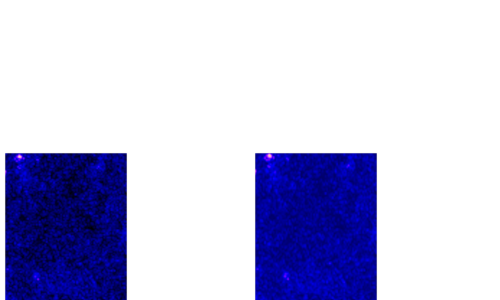

JupyterWgpuCanvas()

In [13]:
# gridplot with 1 row, 2 columns
gp = GridPlot(
    shape=(1, 2),
    controllers=np.array([[0, 0]]) # this is to that we can pan-zoom in sync :D 
)

input_graphic = Image(
    data=input_movie[0], # image data for the first frame
    cmap='gnuplot2' # my favorite colormap
)

mcorr_graphic = Image(
    data=mcorr_movie[0], # image data for the first frame
    cmap='gnuplot2'
)

# add the grahpics to the subplots
gp.subplots[0, 0].add_graphic(input_graphic)
gp.subplots[0, 1].add_graphic(mcorr_graphic)

# make a GUI slider
slider = IntSlider(value=0, min=0, max=input_movie.shape[0] - 1, step=1)

previous_value = 0

# a function to update the frame based on the slider value
def update_frame():
    global previous_value
    if previous_value == slider.value:
        return
    
    input_graphic.update_data(input_movie[slider.value])
    mcorr_graphic.update_data(mcorr_movie[slider.value])
    
# add to the animation so that this is run in every render cycle
gp.add_animations([update_frame])
gp.show()

In [14]:
slider

IntSlider(value=0, max=2999)

In [15]:
gp.canvas.close()

In [16]:
# We can continue from mcorr above and perform CNMF using the mcorr output

# some params for CNMF
params_cnmf =\
{
    'main': # indicates that these are the "main" params for the CNMF algo
        {
            'p': 1,
            'gnb': 2,
            # raises error: no parameter 'merge_thresh' found
            'merge_thr': 0.85,
            'rf': 15,
            'stride_cnmf': 6,
            'K': 4,
            'gSig': [4, 4],
            'ssub': 1,
            'tsub': 1,
            'method_init': 'greedy_roi',
            'min_SNR': 2.0,
            'rval_thr': 0.7,
            'use_cnn': True,
            'min_cnn_thr': 0.8,
            'cnn_lowest': 0.1,
            'decay_time': 0.4,
        },
    'refit': True, # If `True`, run a second iteration of CNMF
}

df.caiman.add_item(
  algo='cnmf',
  name='my_movie',
  input_movie_path=df.iloc[0].mcorr.get_output_path(),  # use mcorr output from a previous item
  params=params_cnmf
)

# run this item
process = df.iloc[-1].caiman.run()
process.wait()

cnmf params {'main': {'p': 1, 'gnb': 2, 'merge_thr': 0.85, 'rf': 15, 'stride_cnmf': 6, 'K': 4, 'gSig': [4, 4], 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}


making memmap


2022-06-20 02:58:23.385858: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-06-20 02:58:23.385947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-06-20 02:58:23.385954: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-06-20 02:58:23.386130: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-06-20 02:58:23.386651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-06-20 02:58:23.386659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-06-20 02:58:23.392746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
5/5 [==============================] - 0s 20ms/step


0

### Look at the CNMF outputs

In [17]:
df = load_batch(batch_path)
df

,algo,name,input_movie_path,params,outputs,uuid
0,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': [24, 24], 'strides': [...",{'mean-projection-path': 2fa75498-d896-46a6-a5...,2fa75498-d896-46a6-a551-dc91a85eb6f2
1,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': [24, 24], 'strides': [...",None,a84e2793-8c65-4585-aaa9-7874b8b28e1f
2,cnmf,my_movie,2fa75498-d896-46a6-a551-dc91a85eb6f2/2fa75498-...,"{'main': {'p': 1, 'gnb': 2, 'merge_thr': 0.85,...",{'mean-projection-path': 227d7485-1177-4b0c-b0...,227d7485-1177-4b0c-b04b-57b62d323123


In [18]:
df.iloc[-1]

algo                                                             cnmf
name                                                         my_movie
input_movie_path    2fa75498-d896-46a6-a551-dc91a85eb6f2/2fa75498-...
params              {'main': {'p': 1, 'gnb': 2, 'merge_thr': 0.85,...
outputs             {'mean-projection-path': 227d7485-1177-4b0c-b0...
uuid                             227d7485-1177-4b0c-b04b-57b62d323123
Name: 2, dtype: object

In [19]:
df.iloc[-1]["outputs"]["success"]

True

In [20]:
# get the motion corrected movie as a memmap
cnmf_movie = df.iloc[-1].cnmf.get_input_memmap()

# we can get the contours of the spatial components
coors, coms = df.iloc[-1].cnmf.get_spatial_contours()

RFBOutputContext()


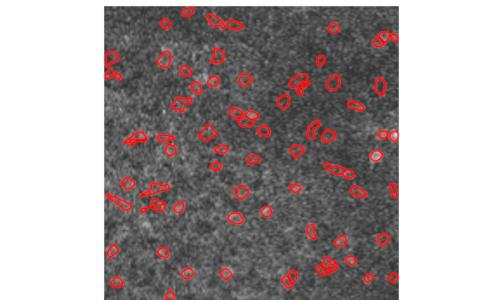

JupyterWgpuCanvas()

In [21]:
# create a simple plot
plot = Plot()

# plot the first frame, transpose so it lines up with contours
image_graphic = plot.image(data=cnmf_movie[0].T, cmap='gray')

# plot all the contours
for coor in coors:
    # line data has to be 3D
    zs = np.ones(coor.shape[0]) # this will place it above the image
    coors_3d = np.dstack([coor[:, 0], coor[:, 1], zs])[0].astype(np.float32)
    
    # red color, just [R, G, B, A] -> red, green, blue, alpha (transparency)
    colors = np.vstack([[1., 0., 0., 1.]] * coors_3d.shape[0]).astype(np.float32)
    plot.line(data=coors_3d, colors=colors)

# make a slider like for mcorr
slider_cnmf = IntSlider(value=0, min=0, max=cnmf_movie.shape[0] - 1, step=1)
    
previous_ix = 0

# animate func just like mcorr viz
def update_frame_cnmf():
    if slider_cnmf.value == previous_ix:
        return
    # update with frame from slider value, again transpose to line up with contours
    image_graphic.update_data(data=cnmf_movie[slider_cnmf.value].T)

plot.add_animations([update_frame_cnmf])
    
plot.show()

In [22]:
slider_cnmf

IntSlider(value=0, max=2999)

In [23]:
plot.canvas.close()

# View the reconstructed movie

RFBOutputContext()


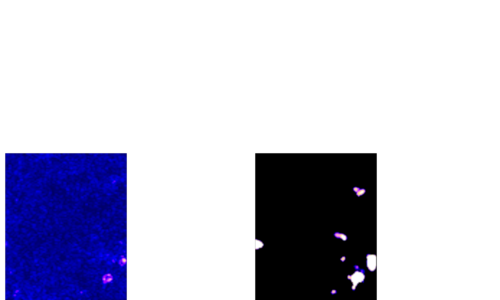

JupyterWgpuCanvas()

In [24]:
# gridplot with 1 row, 2 columns
gp_rcm = GridPlot(
    shape=(1, 2),
    controllers=np.array([[0, 0]]) # this is to that we can pan-zoom in sync :D 
)

# for the mcorr movie
left_graphic = Image(
    data=cnmf_movie[0].T, # image data for the first frame
    cmap='gnuplot2' # my favorite colormap
)

# get the first frame of reconstructed movie
rcm0 = df.iloc[-1].cnmf.get_reconstructed_movie(ixs_frames=(0, 1), add_background=False)[0]

# create the graphic
right_graphic = Image(
    data=rcm0.T, # image data for the first frame
    vmin=10,
    vmax=20,
    cmap='gnuplot2'
)

# add the grahpics to the subplots
gp_rcm.subplots[0, 0].add_graphic(left_graphic)
gp_rcm.subplots[0, 1].add_graphic(right_graphic)

# make a GUI slider
slider_rcm = IntSlider(value=0, min=0, max=cnmf_movie.shape[0] - 1, step=1)

previous_value = 0

# a function to update the frame based on the slider value
def update_rcm_frame():
    global previous_value
    if previous_value == slider_rcm.value:
        return
    
    left_graphic.update_data(cnmf_movie[slider_rcm.value].T)
    
    ixs_frames = (slider_rcm.value, slider_rcm.value + 1)
    
    # get the A x C for just 1 frame
    rcm_frame = df.iloc[-1].cnmf.get_reconstructed_movie(ixs_frames=ixs_frames, add_background=False)[0]
    right_graphic.update_data(rcm_frame.T)
    
# add to the animation so that this is run in every render cycle
gp_rcm.add_animations([update_rcm_frame])
gp_rcm.show()

In [25]:
slider_rcm

IntSlider(value=0, max=2999)

**The reconstructed movie is from all components, not just the ones that passed eval. That's why you're seeing a lot of neuropil etc. here. As I mentioned, the API is still evolving so using `idx_components_good` hasn't been implemented with the reconstructed movie extension**